In [1]:
#!/usr/bin/env python3
import numpy as np
import glob
import matplotlib.pyplot as plt

data_directory = "./vis_project_data/"

# Default weights; used if not set
default_weights = np.array([-1, 0, 1, 2, 2, 3, 5])

# Types of sessions/files:
session_types = ["cog", "so"]
whatdoors = ["indoor", "outdoor"]
whichs = ["base", "inter"]

# Combine to single itteratable list
combined_scenarios = [
    (ses_type, whatdoor, which)
    for ses_type in session_types
    for whatdoor in whatdoors
    for which in whichs
]

################################################################################


def combined_score(filename, weights):
    """Calculates the 'score' for a single session/file.
    Assumes total session duration is 360s, otherwise returns 'nan'.
    This could be modified simply to also return other details of the session."""
    with open(filename, "r") as file:
        score = 0.0
        total_duration = 0.0
        t_end_prev = 0.0
        for count, line in enumerate(file.readlines()):
            # print(count, line)
            data = line.split(",", 4)
            if count == 0:
                continue
            if line[0] == "*":
                break

            t_catagory = int(data[0])
            t_beg = int(data[1])
            t_end = int(data[2])

            if t_beg != t_end_prev:
                print("Error, missing time stamp?")
            t_end_prev = t_end

            assert t_end >= t_beg
            if count == 1:
                assert t_beg == 0

            duration = float(t_end - t_beg)
            total_duration += duration
            score += weights[t_catagory - 1] * duration
        return score / total_duration
        return score if np.abs(total_duration - 1.0) < 1.0e-5 else np.nan


################################################################################


def print_scores(
    ca, peer, cognitive_weights=default_weights, social_weights=default_weights
):
    """Calculates the scores for given ca/peer pair.
    It simply prints the result to screen - to be useful, you will want
    to actually store this data (e.g., return a struct or array etc.).
    """
    trained = "Trained" if "u" <= peer[0] <= "z" else "Untrained"
    print(ca, peer, f"({trained})")
    for ses_type, whatdoor, which in combined_scenarios:

        weights = cognitive_weights if ses_type == "cog" else social_weights

        # glob creates the list of filenames that match the given pattern
        # '*' is a wildcard
        files = glob.glob(
            data_directory + f"{ses_type}-*-{which}-*-{ca}-{peer}-{whatdoor}.dtx"
        )

        if len(files) == 0:
            continue

        scores = []
        for file in files:
            tmp_score = combined_score(file, weights)
            if not np.isnan(tmp_score):
                scores.append(tmp_score)
        scores = np.array(scores)

        mean = scores.mean()
        sdev = scores.std(ddof=1)  # "corrected" sdev
        sem = sdev / np.sqrt(len(scores))
        # Equiv. to:
        # sdev = scores.std()
        # sem = sdev / np.sqrt(len(scores) - 1)

        # len(scores) is the total number of kept (complete) sessions [for this ca/peer]
        # len(files) is the total number of sessions (files) in data directory
        print(
            f"{ses_type:3} {whatdoor:7} {which:5}: {mean:6.3f} +/- {sem:.3f}  [{len(scores)}/{len(files)}]"
        )


################################################################################
def unique_pairs():
    """Returns list of unique ca/peer pairs"""
    all_files = glob.glob(data_directory + "/*.dtx")
    list = []
    for file in all_files:
        t = file.split("-")
        list.append([t[4], t[5]])

    return np.unique(list, axis=0)


################################################################################

if __name__ == "__main__":

    # Example usage:

    ca_peer_list = unique_pairs()
    print(ca_peer_list)

    print()

    # From the thesis:
    soc_weights = np.array([-1, 0, 1, 2, 2, 3, 5])

    # Match table 5.1 of thesis
    # cog_weights = np.array([-1, 0, 1, 2, 2, 3, 5])

    # Match matlab example:
    cog_weights = np.array([0, -1, 1, 2, 2, 3, 5])

    # Example:
    ca = "albert"
    peer = "lydia"
    print_scores("albert", "lydia", cog_weights, soc_weights)

    # Or, for all pairs:
    for ca, peer in ca_peer_list:
        print()
        print_scores(ca, peer, cog_weights, soc_weights)

################################################################################




[['albert' 'lydia']
 ['albert' 'ulrich']
 ['barry' 'mario']
 ['barry' 'viola']
 ['chris' 'nellie']
 ['chris' 'wendy']
 ['dana' 'oscar']
 ['dana' 'xavier']
 ['ellie' 'peter']
 ['ellie' 'yoshi']
 ['ellie' 'zara']]

albert lydia (Untrained)
cog indoor  base :  0.033 +/- 0.027  [4/4]
cog indoor  inter:  0.168 +/- 0.084  [13/13]
cog outdoor base :  0.245 +/- 0.110  [4/4]
cog outdoor inter:  0.347 +/- 0.101  [10/10]
so  indoor  base :  0.097 +/- 0.043  [4/4]
so  indoor  inter:  0.129 +/- 0.034  [13/13]
so  outdoor base :  0.101 +/- 0.089  [4/4]
so  outdoor inter:  0.055 +/- 0.016  [10/10]

albert lydia (Untrained)
cog indoor  base :  0.033 +/- 0.027  [4/4]
cog indoor  inter:  0.168 +/- 0.084  [13/13]
cog outdoor base :  0.245 +/- 0.110  [4/4]
cog outdoor inter:  0.347 +/- 0.101  [10/10]
so  indoor  base :  0.097 +/- 0.043  [4/4]
so  indoor  inter:  0.129 +/- 0.034  [13/13]
so  outdoor base :  0.101 +/- 0.089  [4/4]
so  outdoor inter:  0.055 +/- 0.016  [10/10]

albert ulrich (Trained)
cog ind

In [2]:
def calculate_scores(
    ca, peer, cognitive_weights=default_weights, social_weights=default_weights
):
    """Calculates the scores for given ca/peer pair.
    It simply prints the result to screen - to be useful, you will want
    to actually store this data (e.g., return a struct or array etc.).
    """
    trained = "Trained" if "u" <= peer[0] <= "z" else "Untrained"
    print(ca, peer, f"({trained})")
    scores = {}
    for ses_type, whatdoor, which in combined_scenarios:

        weights = cognitive_weights if ses_type == "cog" else social_weights

        # glob creates the list of filenames that match the given pattern
        # '*' is a wildcard
        files = glob.glob(
            data_directory + f"{ses_type}-*-{which}-*-{ca}-{peer}-{whatdoor}.dtx"
        )

        if len(files) == 0:
            continue

        scores[whatdoor] = []
        for file in files:
            tmp_score = combined_score(file, weights)
            if not np.isnan(tmp_score):
                scores[whatdoor].append(tmp_score)
    return scores
    

[['albert' 'lydia']
 ['albert' 'ulrich']
 ['barry' 'mario']
 ['barry' 'viola']
 ['chris' 'nellie']
 ['chris' 'wendy']
 ['dana' 'oscar']
 ['dana' 'xavier']
 ['ellie' 'peter']
 ['ellie' 'yoshi']
 ['ellie' 'zara']]

albert lydia (Untrained)


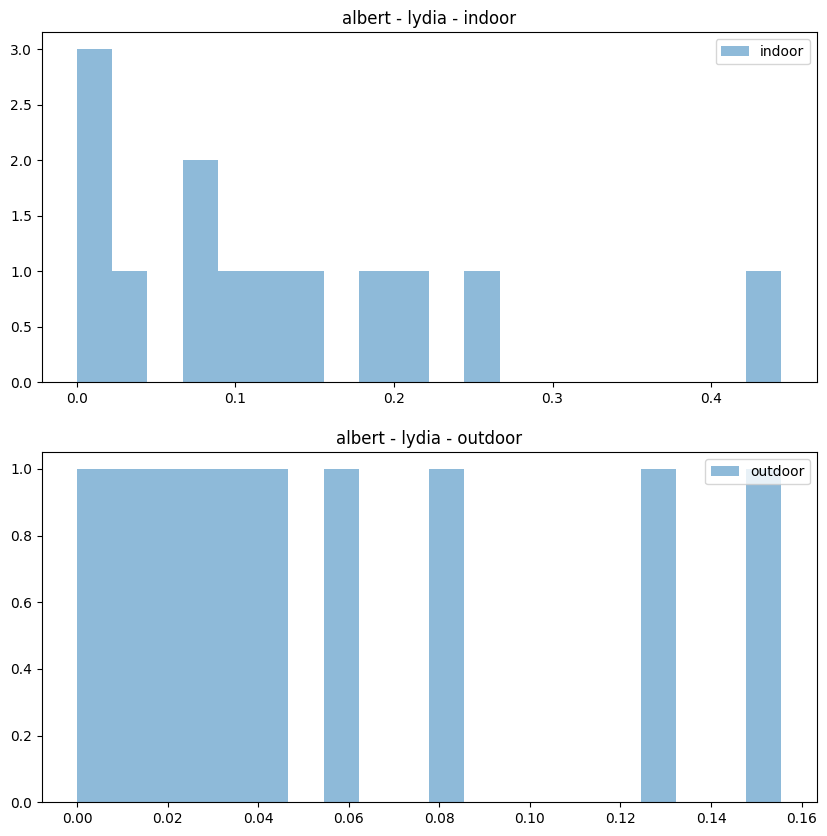


albert lydia (Untrained)


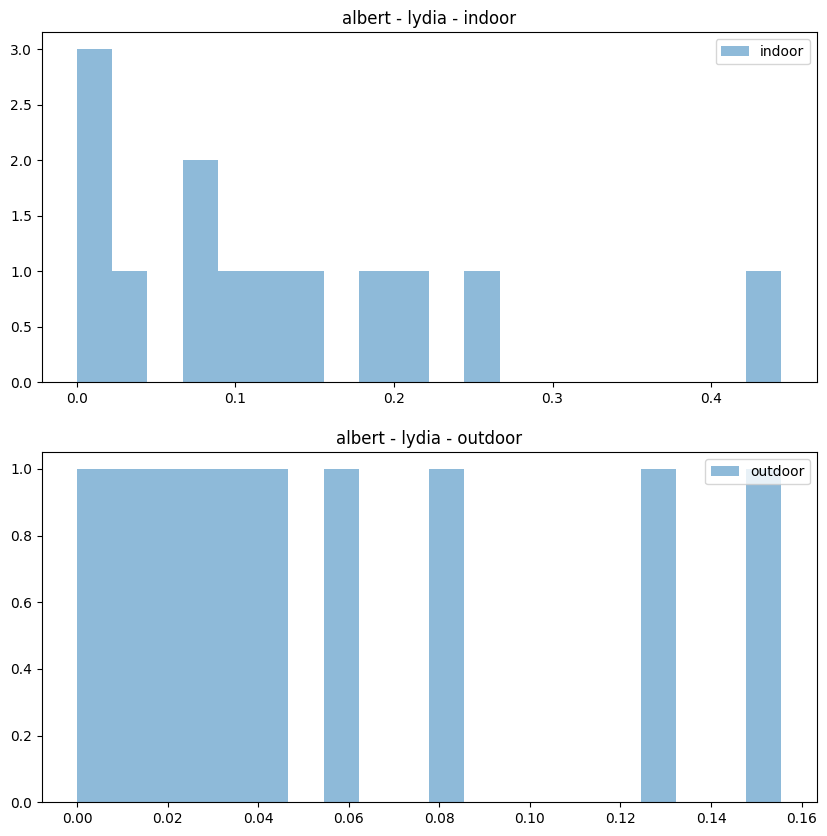


albert ulrich (Trained)


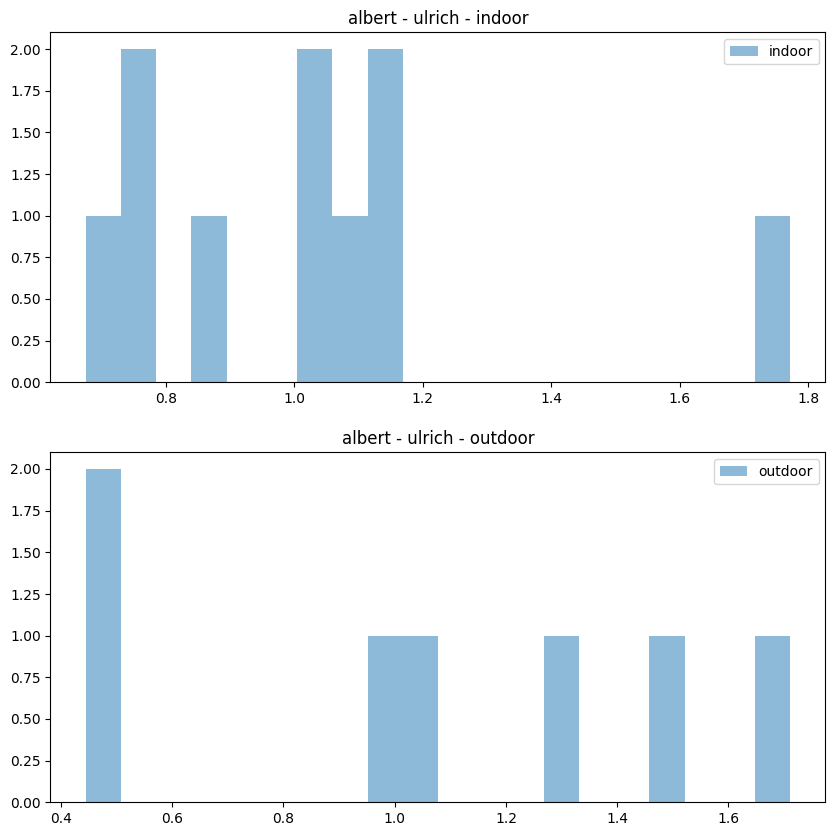


barry mario (Untrained)


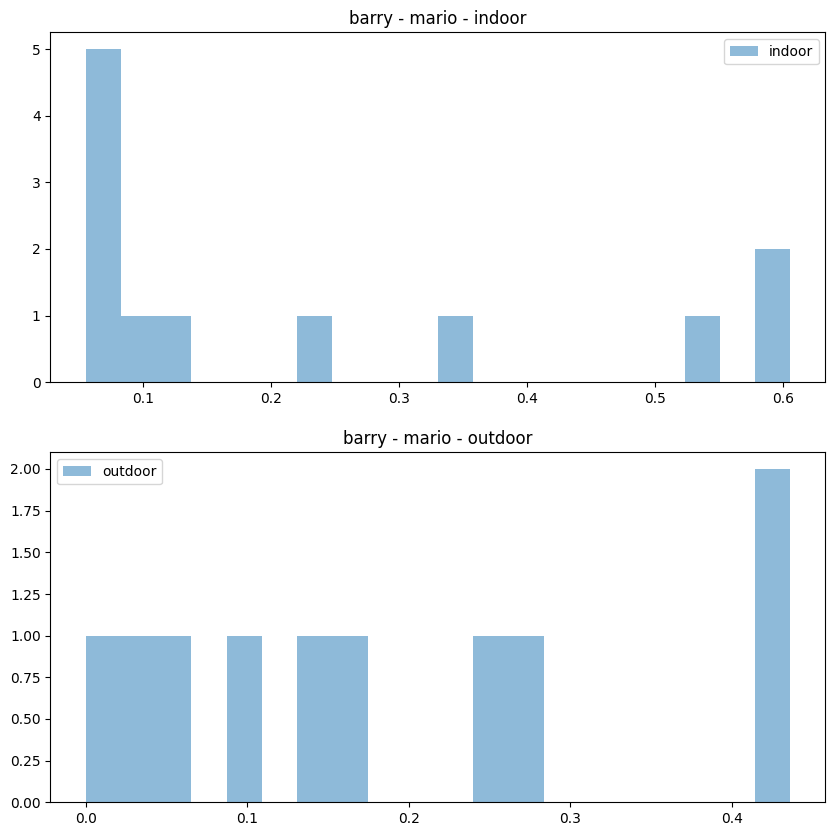


barry viola (Trained)


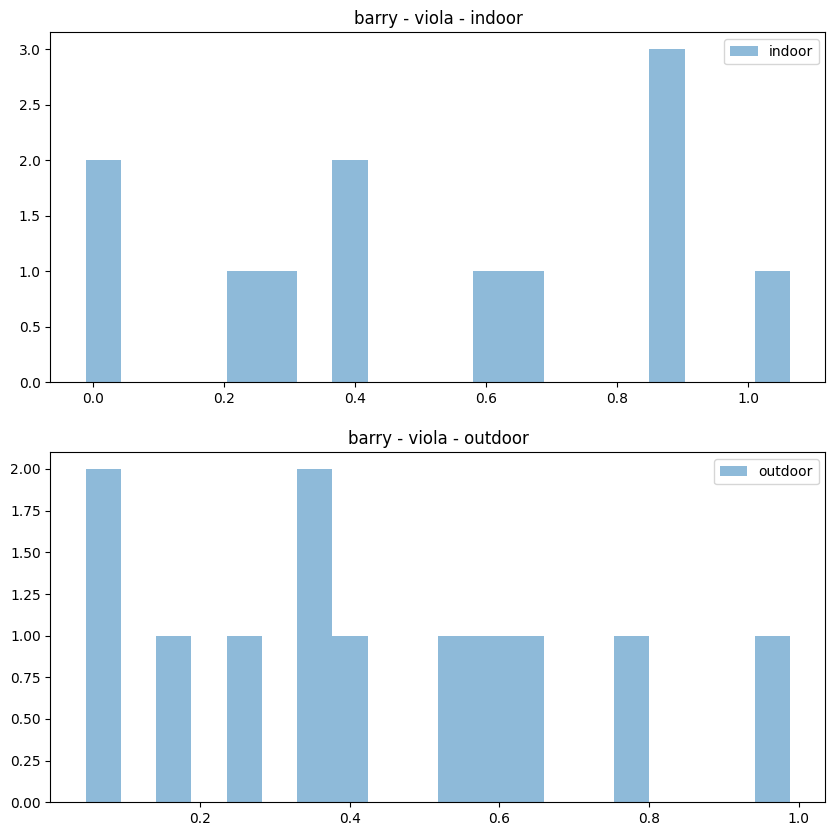


chris nellie (Untrained)


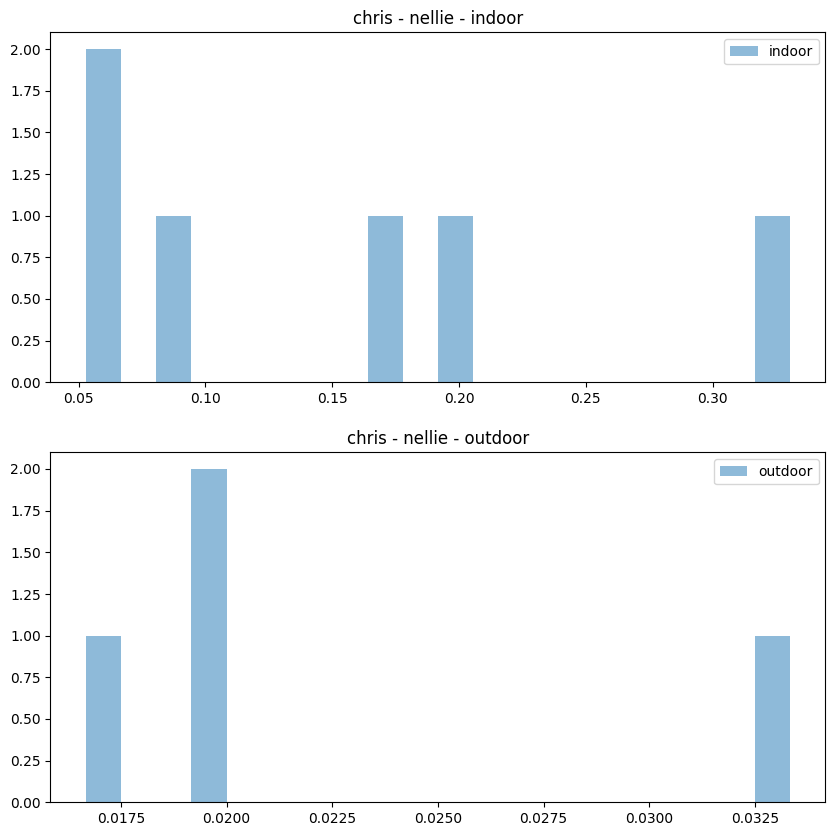


chris wendy (Trained)


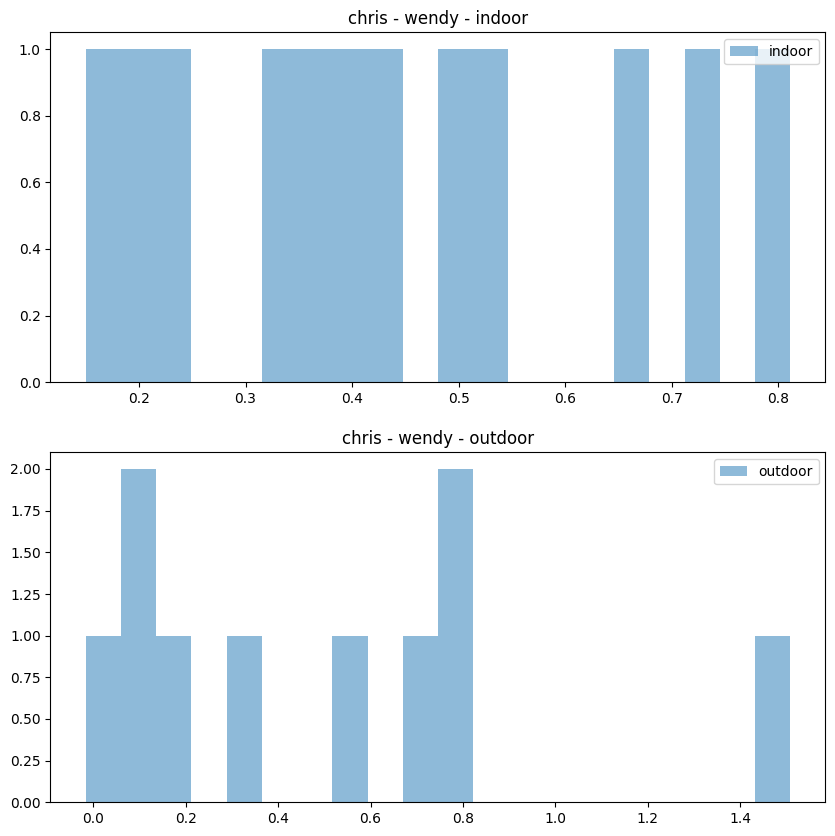


dana oscar (Untrained)


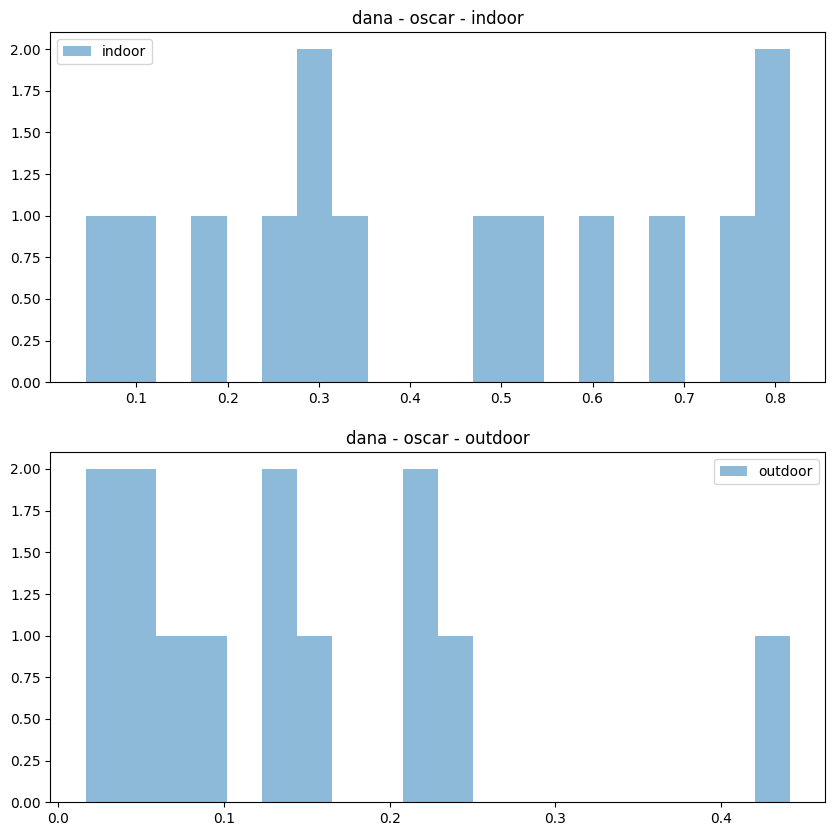


dana xavier (Trained)


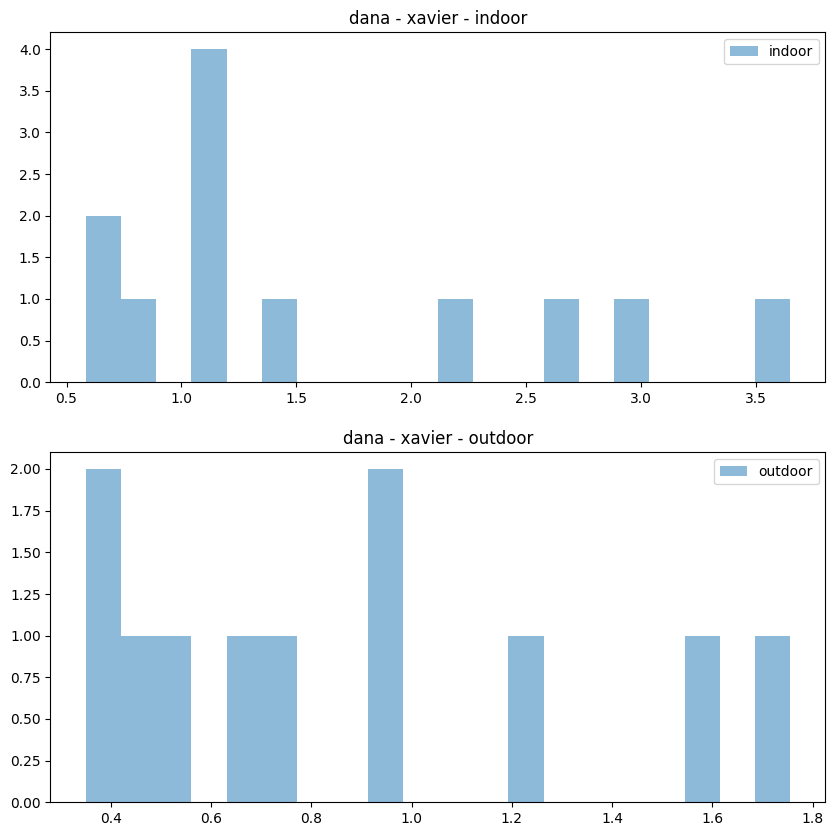


ellie peter (Untrained)


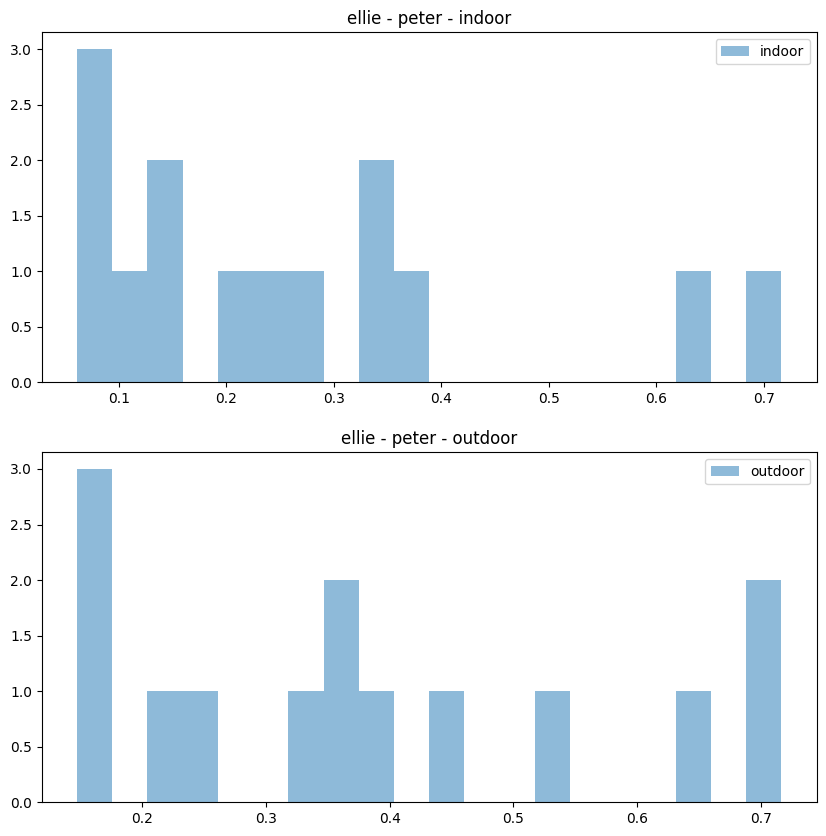


ellie yoshi (Trained)


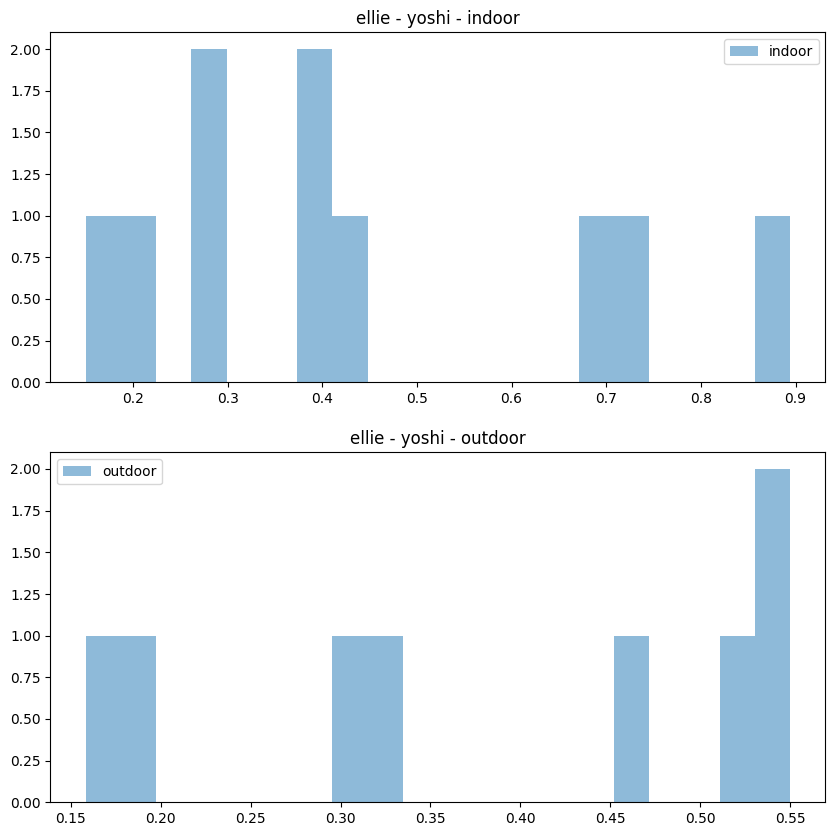


ellie zara (Trained)


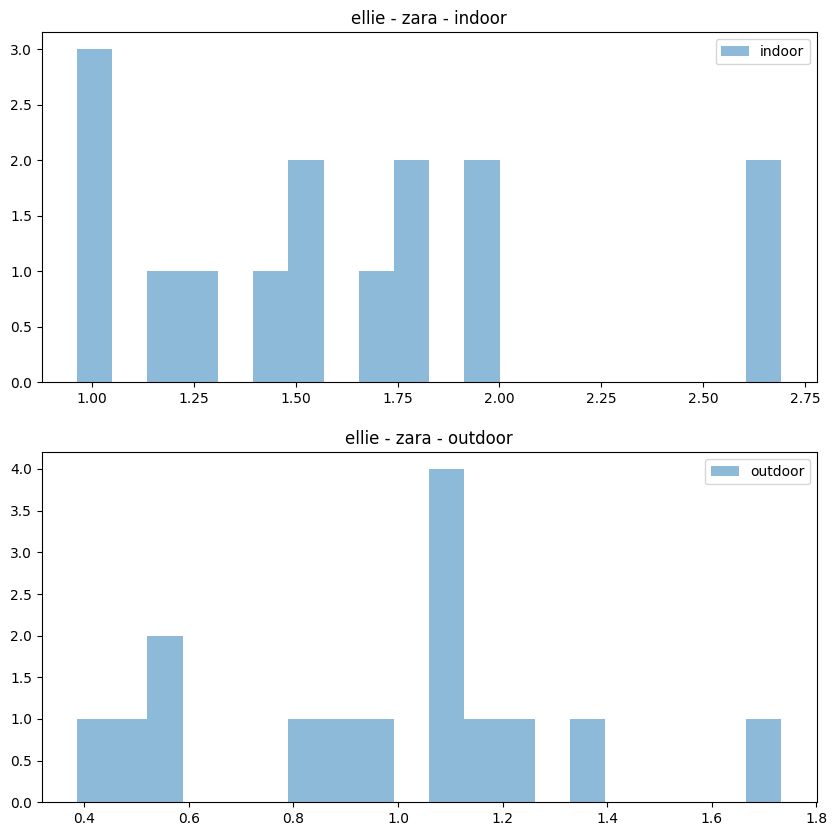

In [3]:
def plot_scores(scores, ca, peer):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    for i, whatdoor in enumerate(scores.keys()):
        axs[i].hist(scores[whatdoor], bins=20, alpha=0.5, label=whatdoor)
        axs[i].set_title(f"{ca} - {peer} - {whatdoor}")
        axs[i].legend()
    plt.show()

if __name__ == "__main__":

    # Example usage:

    ca_peer_list = unique_pairs()
    print(ca_peer_list)

    print()

    # From the thesis:
    soc_weights = np.array([-1, 0, 1, 2, 2, 3, 5])

    # Match table 5.1 of thesis
    # cog_weights = np.array([-1, 0, 1, 2, 2, 3, 5])

    # Match matlab example:
    cog_weights = np.array([0, -1, 1, 2, 2, 3, 5])

    # Example:
    ca = "albert"
    peer = "lydia"
    scores = calculate_scores("albert", "lydia", cog_weights, soc_weights)
    plot_scores(scores, "albert", "lydia")

    # Or, for all pairs:
    for ca, peer in ca_peer_list:
        print()
        scores = calculate_scores(ca, peer, cog_weights, soc_weights)
        plot_scores(scores, ca, peer)

[['albert' 'lydia']
 ['albert' 'ulrich']
 ['barry' 'mario']
 ['barry' 'viola']
 ['chris' 'nellie']
 ['chris' 'wendy']
 ['dana' 'oscar']
 ['dana' 'xavier']
 ['ellie' 'peter']
 ['ellie' 'yoshi']
 ['ellie' 'zara']]


albert lydia (Untrained)


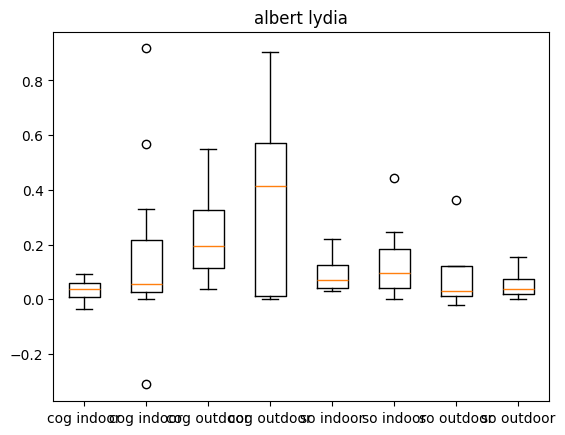


albert ulrich (Trained)


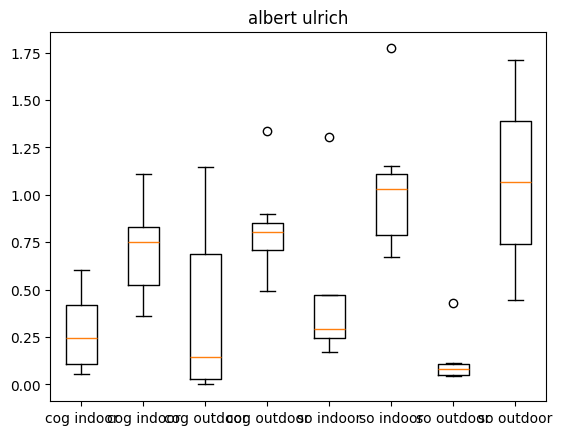


barry mario (Untrained)


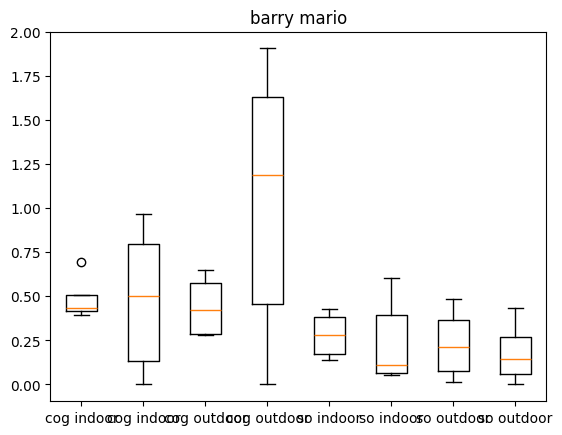


barry viola (Trained)


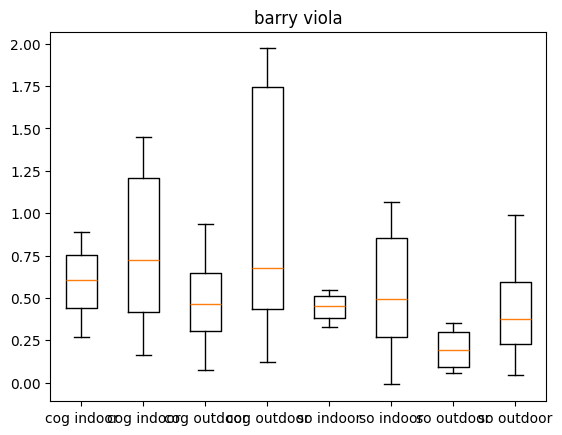


chris nellie (Untrained)


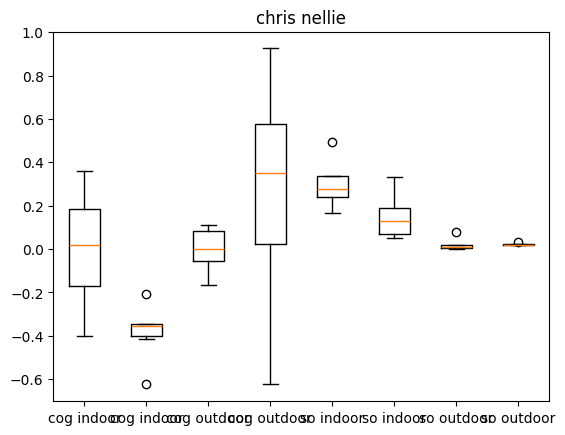


chris wendy (Trained)


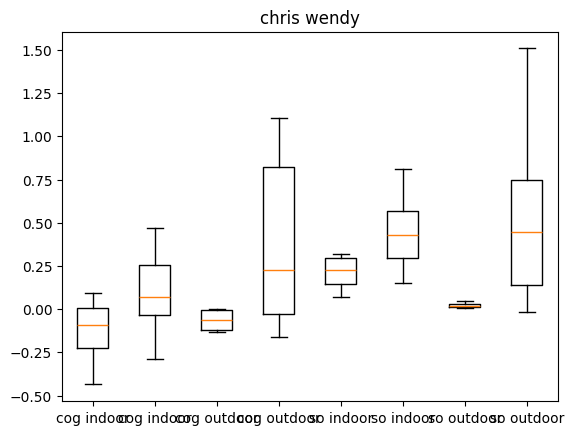


dana oscar (Untrained)


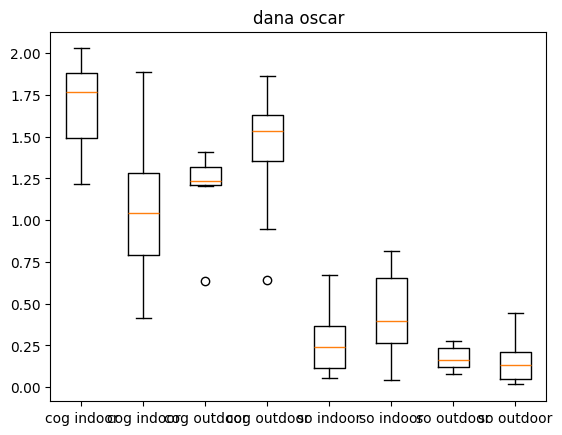


dana xavier (Trained)


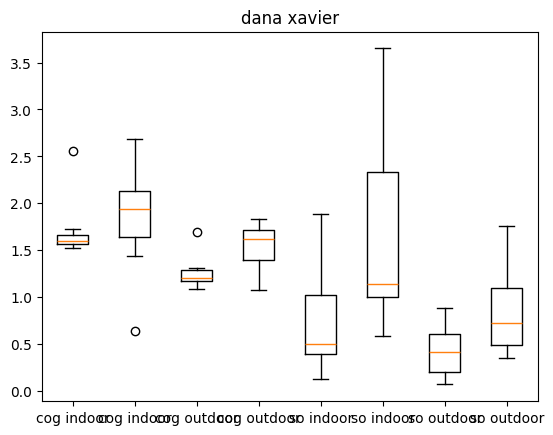


ellie peter (Untrained)


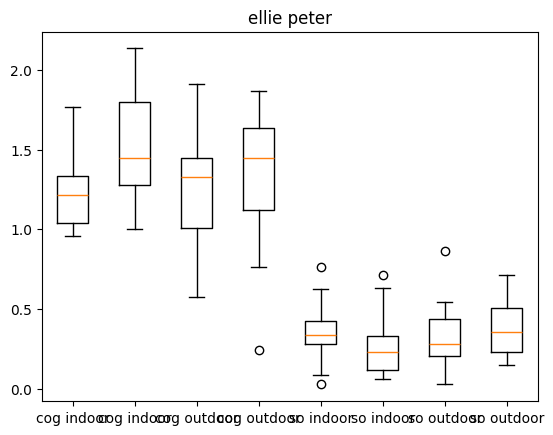


ellie yoshi (Trained)


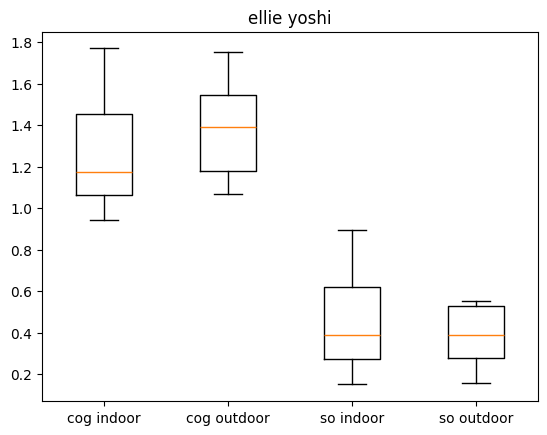


ellie zara (Trained)


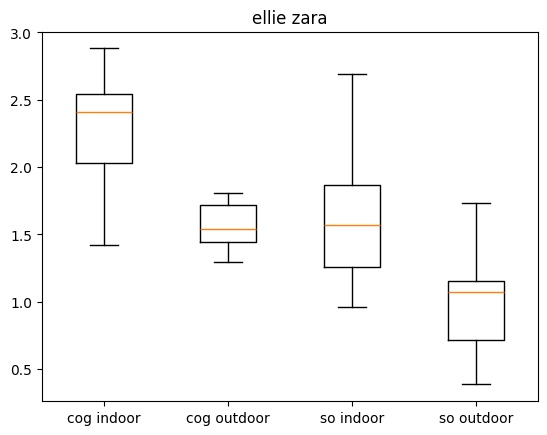

In [5]:
import matplotlib.pyplot as plt

def print_scores_plot(
    ca, peer, cognitive_weights=default_weights, social_weights=default_weights
):
    """Calculates the scores for given ca/peer pair and plots box plots for indoor and outdoor cognitive and social interactions."""
    trained = "Trained" if "u" <= peer[0] <= "z" else "Untrained"
    print(ca, peer, f"({trained})")

    data = []
    labels = []

    for ses_type, whatdoor, which in combined_scenarios:

        weights = cognitive_weights if ses_type == "cog" else social_weights

        # glob creates the list of filenames that match the given pattern
        # '*' is a wildcard
        files = glob.glob(
            data_directory + f"{ses_type}-*-{which}-*-{ca}-{peer}-{whatdoor}.dtx"
        )

        if len(files) == 0:
            continue

        scores = []
        for file in files:
            tmp_score = combined_score(file, weights)
            if not np.isnan(tmp_score):
                scores.append(tmp_score)

        data.append(scores)
        labels.append(f"{ses_type} {whatdoor}")

    fig, ax = plt.subplots()
    ax.boxplot(data)
    ax.set_xticklabels(labels)
    ax.set_title(f"{ca} {peer}")
    plt.show()


if __name__ == "__main__":

    # Example usage:

    ca_peer_list = unique_pairs()
    print(ca_peer_list)

    print()

    # From the thesis:
    soc_weights = np.array([-1, 0, 1, 2, 2, 3, 5])

    # Match table 5.1 of thesis
    # cog_weights = np.array([-1, 0, 1, 2, 2, 3, 5])

    # Match matlab example:
    cog_weights = np.array([0, -1, 1, 2, 2, 3, 5])

    for ca, peer in ca_peer_list:
        print()
        print_scores_plot(ca, peer, cog_weights, soc_weights)